# Local Global Trend (LGT)

In this section, we will cover:

- LGT model structure
- difference between DLT and LGT
- syntax to call LGT classes with different estimation methods

**LGT** stands for Local and Global Trend and is a refined model from **Rlgt** [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html).  The main difference is that LGT is an additive form taking log-transformation response as the modeling response.  This essentially converts the model into a multiplicative with some advantages [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  **However, one drawback of this approach is that negative response values are not allowed due to the existence of the global trend term and because of that we start to deprecate the support of regression of this model.**

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
print(orbit.__version__)

1.1.2


## Model Structure

$$
\begin{align*}
 y_{t}  &= \mu_t + s_t   + \epsilon_t \\
\mu_t &= l_{t-1} + \xi_1 b_{t-1} + \xi_2 l_{t-1}^{\lambda}\\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process,

$$
\begin{align*}
l_t &= \rho_l(y_t - s_t) + (1-\rho_l)l_{t-1}\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t ) + (1-\rho_s)s_t
\end{align*}
$$

Unlike **DLT** model which has a deterministic trend, **LGT** introduces a hybrid trend where it consists of 

- local trend takes on a fraction $\xi_1$ rather than a damped factor
- global trend is with a auto-regrssive term $\xi_2$ and a power term $\lambda$

We will continue to use the *iclaims* data with 52 weeks train-test split.

In [3]:
# load data
df = load_iclaims()
# define date and response column
date_col = 'week'
response_col = 'claims'
df.dtypes
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## LGT Model

In orbit, we provide three methods for LGT model estimation and inferences, which are
* MAP
* MCMC (also providing the point estimate method, `mean` or `median`), which is also the default
* SVI

Orbit follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods.

In this notebook, we will only cover MAP and MCMC methods. Refer to [this notebook](https://github.com/uber/orbit/blob/dev/docs/tutorials/pyro_basic.ipynb) for the pyro estimation.

### LGT - MAP

To use MAP, specify the estimator as `stan-map`.

In [4]:
lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .


In [5]:
%%time
lgt.fit(df=train_df)

CPU times: user 218 ms, sys: 8.52 ms, total: 226 ms
Wall time: 405 ms


In [6]:
predicted_df = lgt.predict(df=test_df)

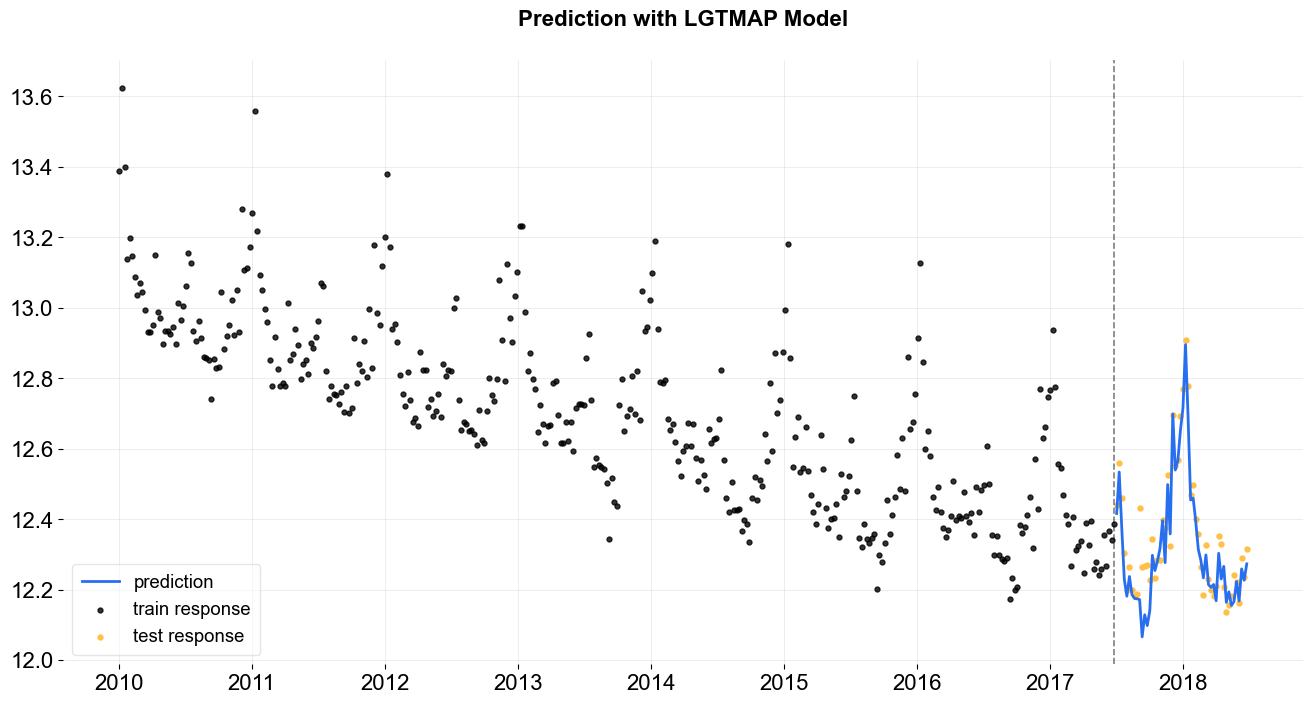

In [7]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with LGTMAP Model')

### LGT - MCMC

To use MCMC sampling, specify the estimator as `stan-mcmc` (the default). 

* By dedault, full Bayesian samples will be used for the predictions: for each set of parameter posterior samples, the prediction will be conducted once and the final predictions are aggregated over all the results. To be specific, the final predictions will be the median (aka 50th percentile) along with any additional percentiles provided. One can use `.get_posterior_samples()` to extract the samples for all sampling parameters.

* One can also specify `point_method` (either `mean` or `median`) via `.fit` to have the point estimate: the parameter posterior samples are aggregated first (mean or median) then conduct the prediction once.

#### LGT - full

In [8]:
lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [9]:
%%time
lgt.fit(df=train_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 77.7 ms, sys: 63.6 ms, total: 141 ms
Wall time: 5.86 s


In [10]:
predicted_df = lgt.predict(df=test_df)

In [11]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.138702,12.236653,12.325029
48,2018-06-03,12.042856,12.164003,12.282972
49,2018-06-10,12.177416,12.271215,12.393355
50,2018-06-17,12.126099,12.228332,12.343101
51,2018-06-24,12.151659,12.278477,12.375120


In [12]:
lgt.get_posterior_samples().keys()

odict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lgt_sum', 'gt_pow', 'lt_coef', 'gt_coef', 's', 'sea_sm'])

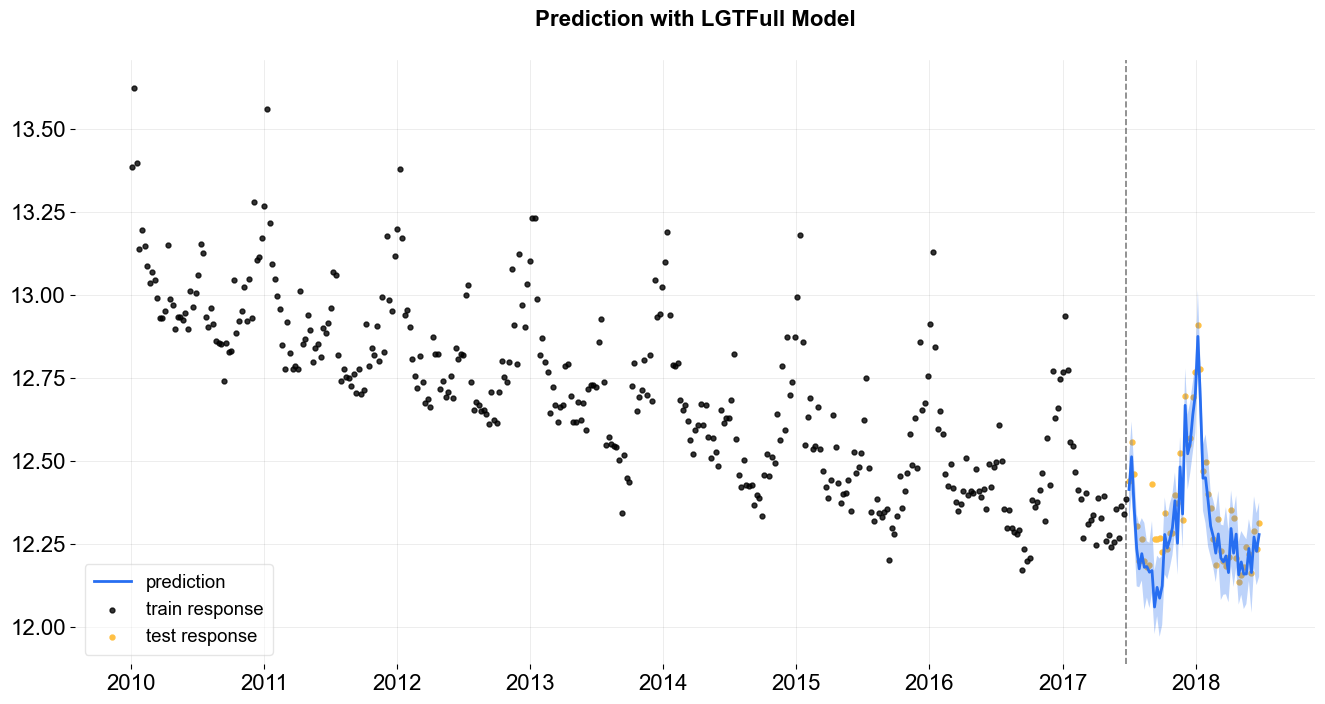

In [13]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Prediction with LGTFull Model')

#### LGT - point estimate

In [14]:
lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [15]:
%%time
lgt.fit(df=train_df, point_method='mean')

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 83 ms, sys: 71.9 ms, total: 155 ms
Wall time: 6.13 s


In [16]:
predicted_df = lgt.predict(df=test_df)

In [17]:
predicted_df.tail(5)

,week,prediction
47,2018-05-27,12.198260
48,2018-06-03,12.134447
49,2018-06-10,12.227925
50,2018-06-17,12.195388
51,2018-06-24,12.241482


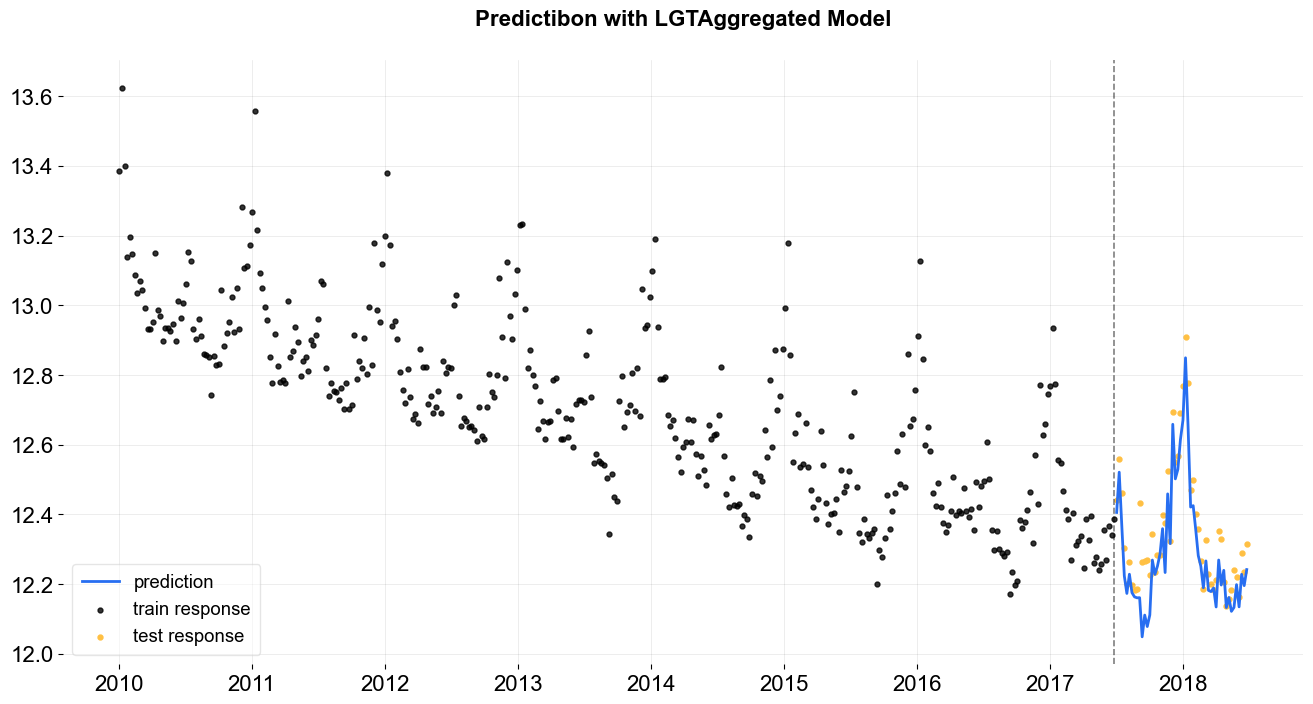

In [18]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Predictibon with LGTAggregated Model')